<b><h1>Books Recommendation System

In [1]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

<b><h3>Dataset

In [2]:
books = pd.read_csv(r"/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
users = pd.read_csv(r"/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
ratings = pd.read_csv(r"/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271379, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


<b><h3>Pre-processing

<b>Books Dataset Pre-processing

In [3]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:

books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [5]:
books.at[187689 ,'Book-Author'] = 'Other'
books.at[187700 ,'Book-Author'] = 'Other'
books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [6]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037])

In [7]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [8]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher


In [9]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [10]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [11]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [12]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [13]:
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [14]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [15]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [16]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271066 entries, 0 to 271065
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271066 non-null  object
 1   Book-Title           271066 non-null  object
 2   Book-Author          271066 non-null  object
 3   Year-Of-Publication  271066 non-null  int64 
 4   Publisher            271064 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [17]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


<b>Users Dataset Pre-processing

In [18]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [19]:
## Checking null values
print(users.isna().sum())               

User-ID          0
Location         0
Age         110762
dtype: int64


In [20]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [21]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [22]:
mean = round(required['Age'].mean())   
mean

35

In [23]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean 
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [24]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values 
print(count_no_state)     #printing the states which didnt have any values

4659
16044


In [25]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [27]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


<b>Books-Ratings Dataset Pre-processing

In [28]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [29]:
## Checking for null values
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [30]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [31]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [32]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])    
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [33]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [34]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [35]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [36]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


<h3><b>Merging of all three Tables

<b>Merging Books, Users and Rating Tables in One

In [37]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031648 entries, 0 to 1031647
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031648 non-null  object
 1   Book-Title           1031648 non-null  object
 2   Book-Author          1031648 non-null  object
 3   Year-Of-Publication  1031648 non-null  int64 
 4   Publisher            1031646 non-null  object
 5   User-ID              1031648 non-null  int64 
 6   Book-Rating          1031648 non-null  int64 
 7   Age                  1031648 non-null  int64 
 8   City                 1031648 non-null  object
 9   State                1031648 non-null  object
 10  Country              1031648 non-null  object
dtypes: int64(4), object(7)
memory usage: 94.5+ MB


In [38]:

dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
                                
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)

<h3><b>Data Visualization

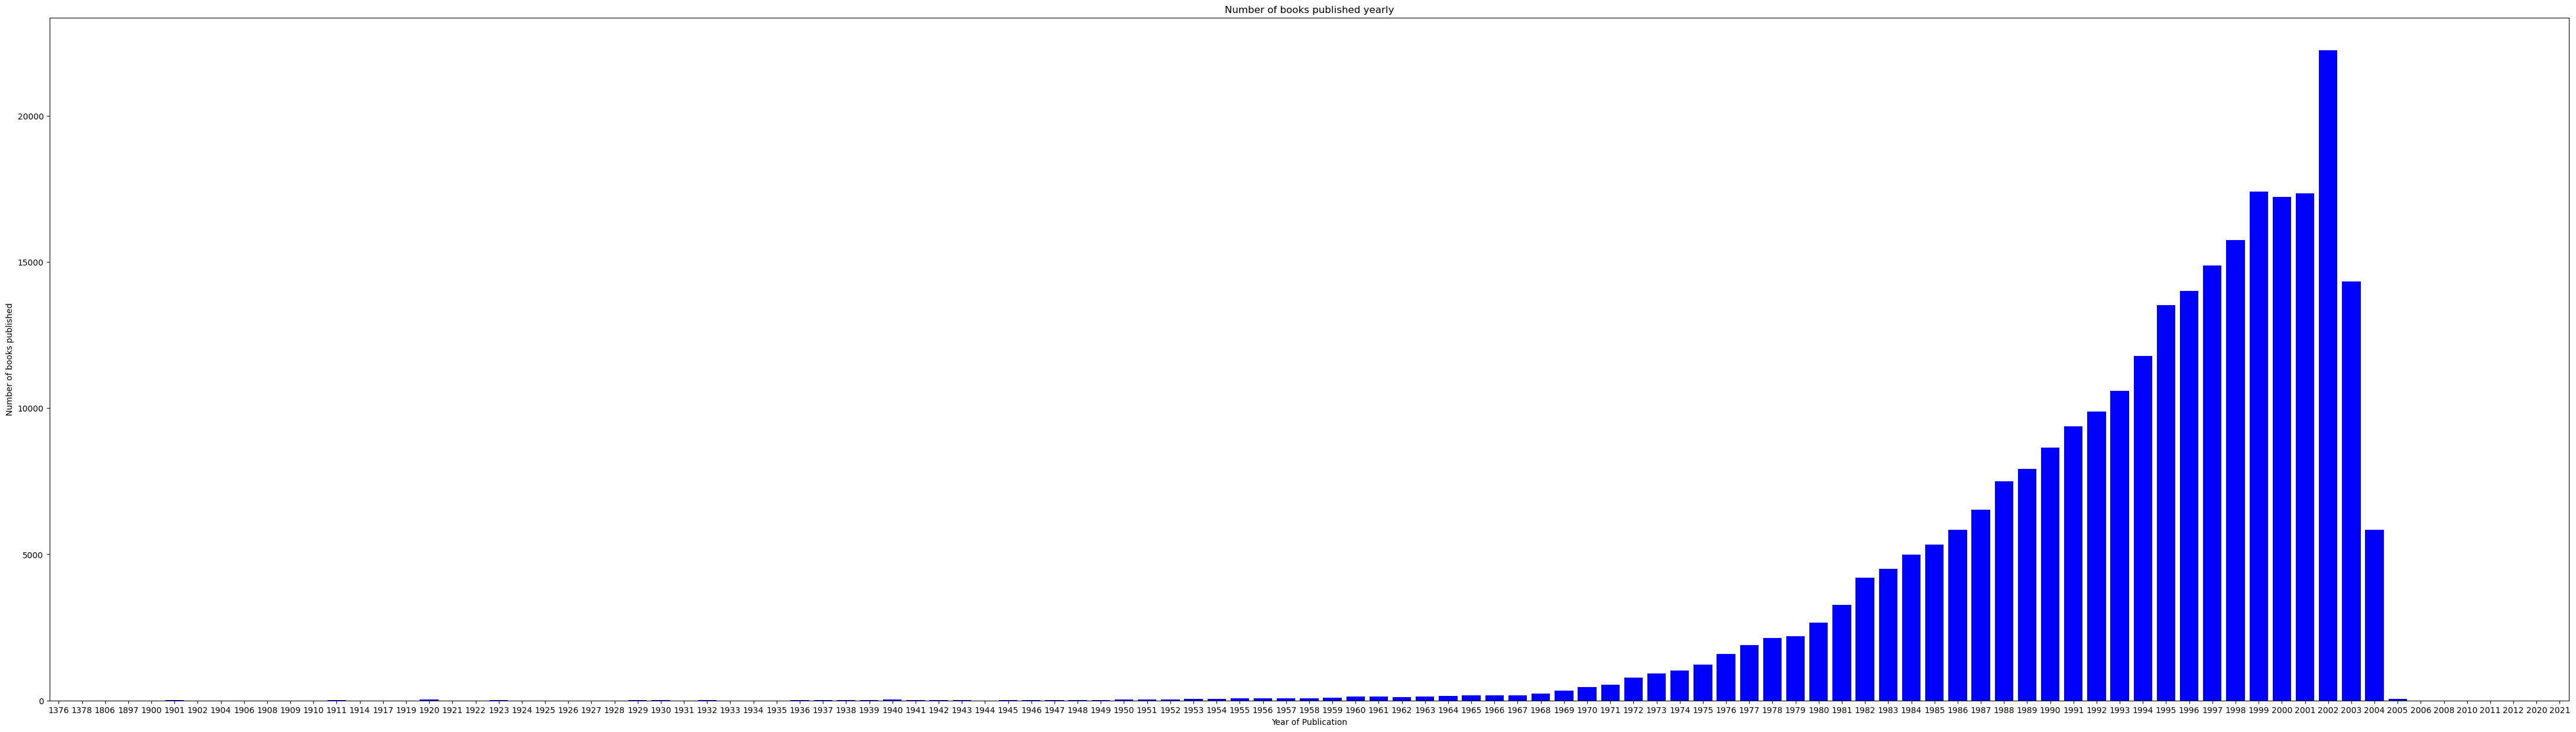

In [39]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 15)')

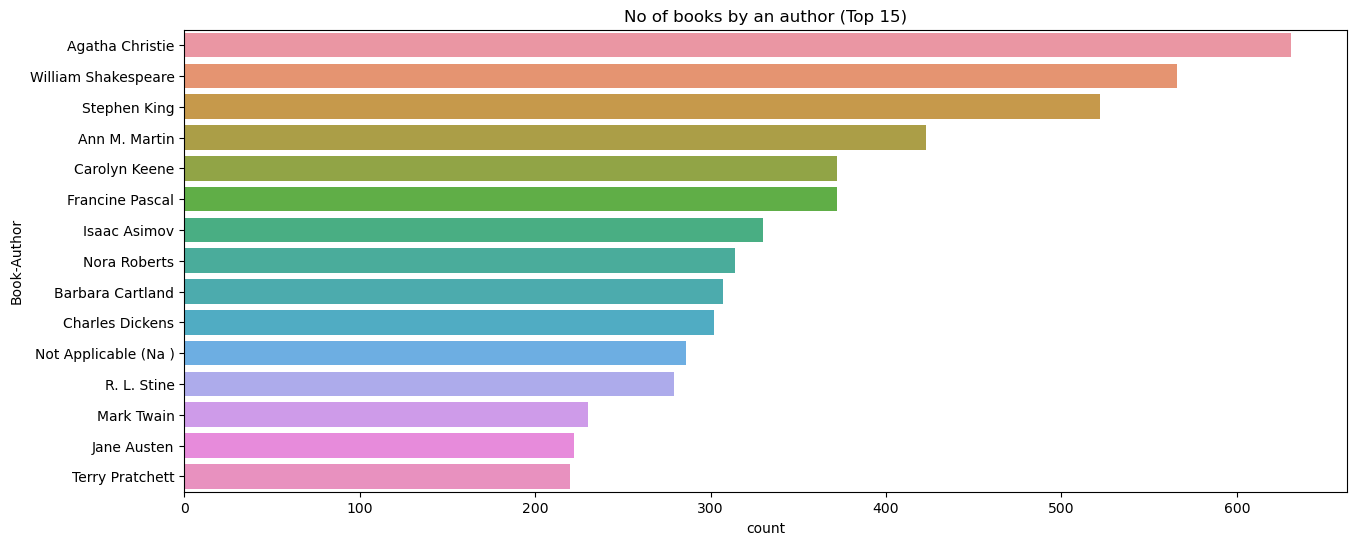

In [40]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

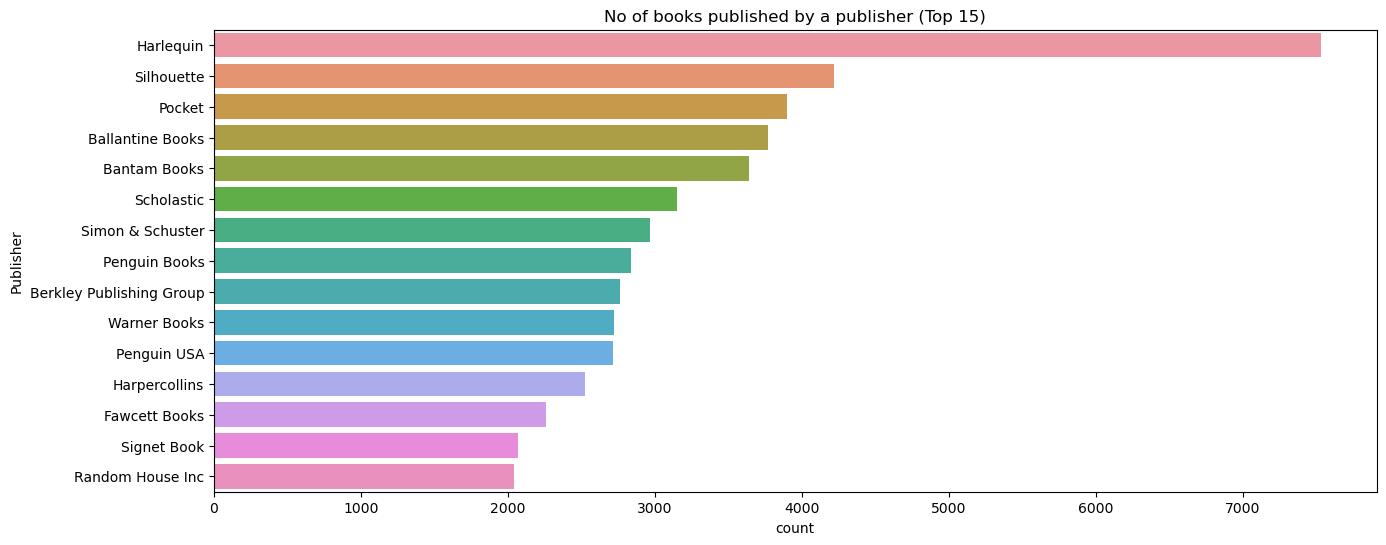

In [41]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")

<Axes: xlabel='Book-Rating', ylabel='count'>

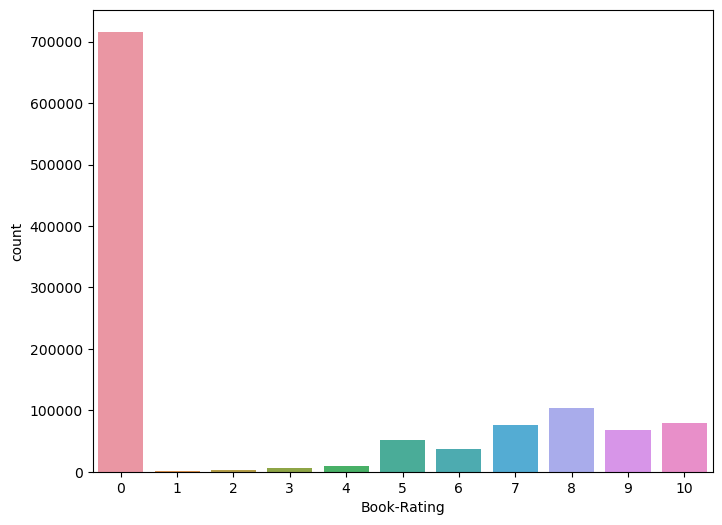

In [42]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

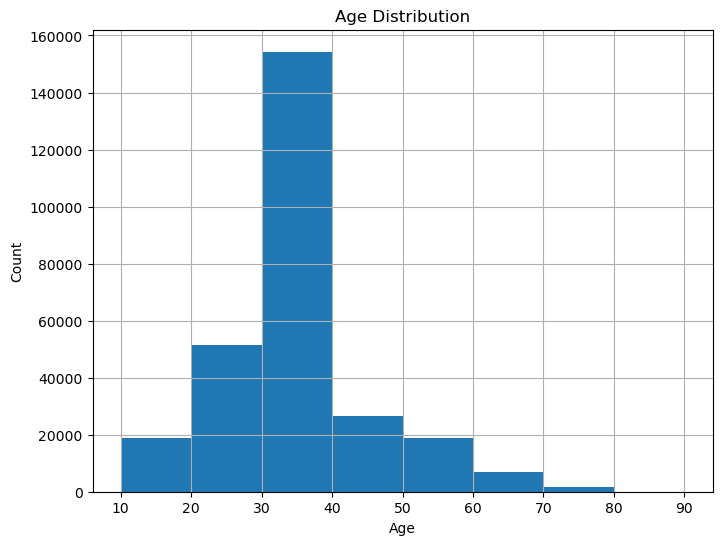

In [43]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'No of readers from each state (Top 15)')

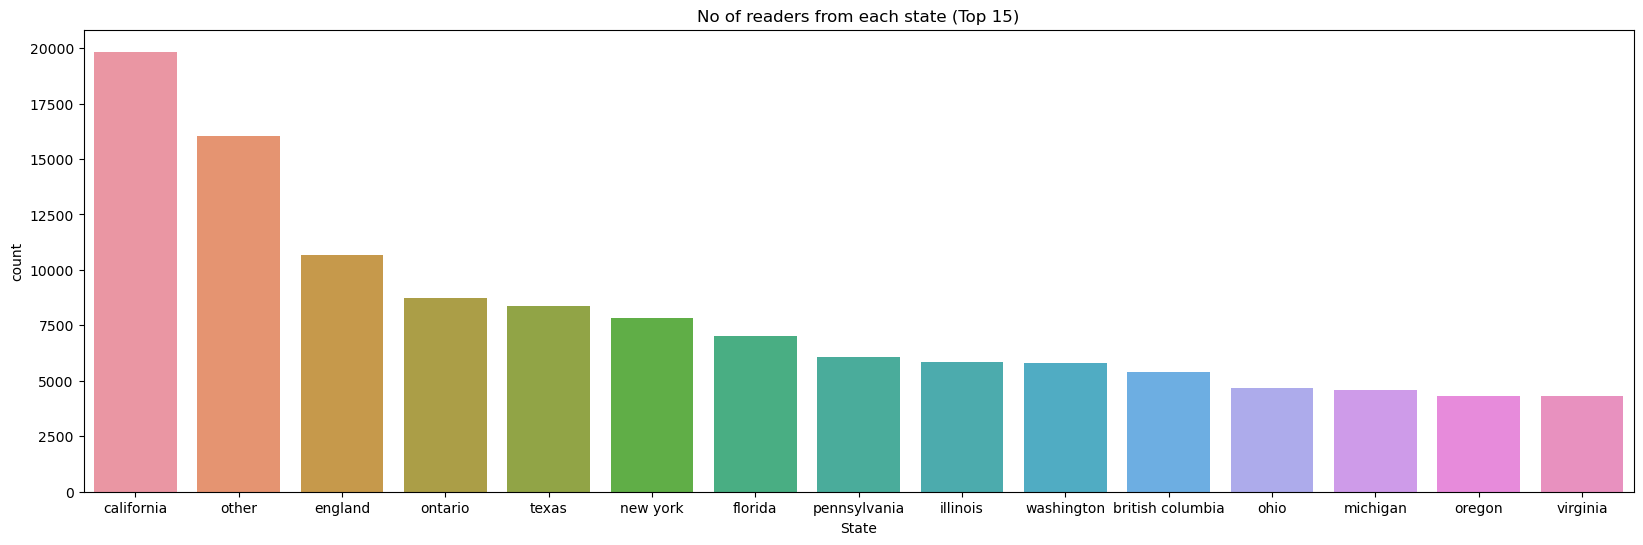

In [44]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

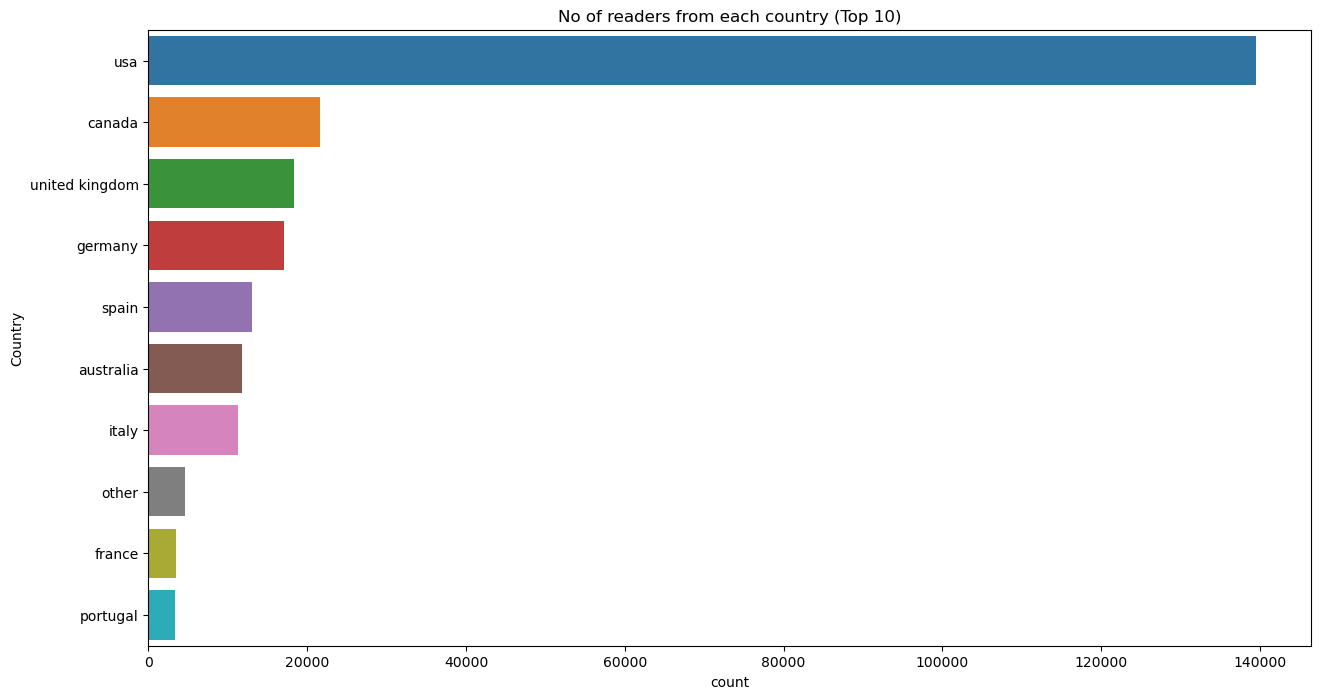

In [45]:
plt.figure(figsize=(15,8))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

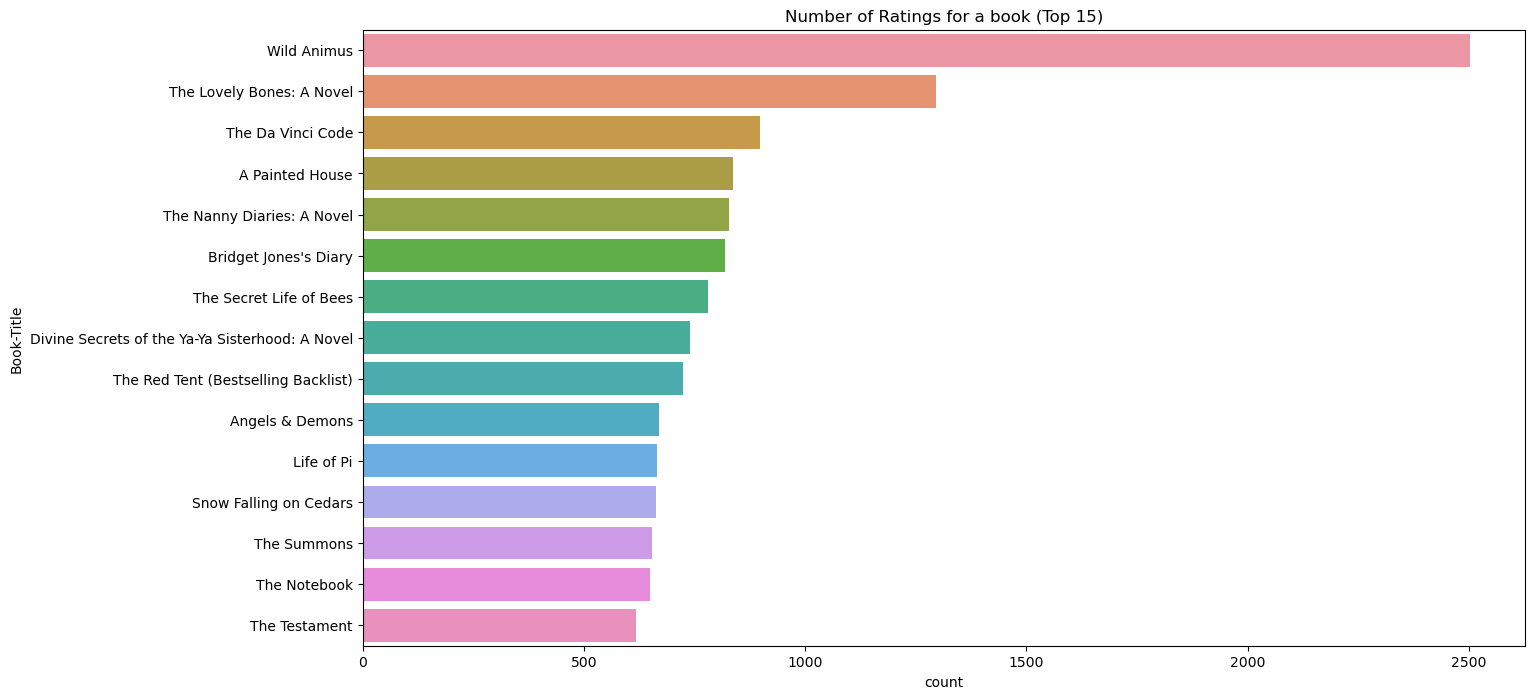

In [46]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

In [47]:
def color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(188)
    s = int(100.0 * 255 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 160)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

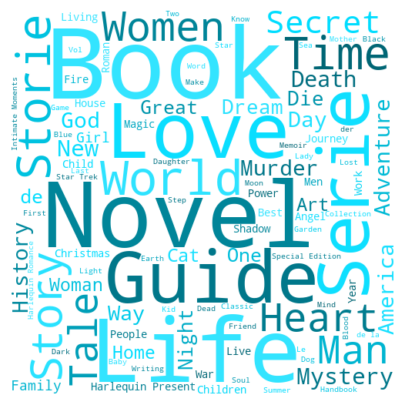

In [48]:
from wordcloud import WordCloud,STOPWORDS
plt.subplots(figsize=(5,5))
wc = WordCloud(background_color="white", max_words=100,
               stopwords=STOPWORDS, max_font_size=128,
               random_state=42, width=500, height=500,color_func=color_func)
wc.generate(' '.join(books['Book-Title']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

****<h2>1.Collaborative Filtering****

Cosine Similarity based Recommendation (Item-Item)

In [49]:
ratings_with_name = ratings.merge(books,on='ISBN')

In [50]:
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
padhe_likhe_users = x[x].index
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(padhe_likhe_users)]
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]
pt = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')
pt.fillna(0,inplace=True)

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores = cosine_similarity(pt)
similarity_scores.shape

(707, 707)

In [52]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def recommend(book_name):
    index = np.where(pt.index == book_name)[0][0]
    similarity_scores = cosine_similarity(pt.values)
    similar_items = sorted(list(enumerate(similarity_scores[index])), key=lambda x: x[1], reverse=True)[1:]
    
    recommended_books = []
    for i in similar_items:
        recommended_books.append(pt.index[i[0]])

    # Number of relevant recommendations
    relevant_items = final_ratings[final_ratings['Book-Title'].isin(recommended_books)]
    num_relevant_recommendations = len(relevant_items)

    # Total number of recommendations
    total_recommendations = len(recommended_books)

    # Total number of relevant items
    total_relevant_items = len(final_ratings)

    # Precision
    precision = num_relevant_recommendations / total_recommendations if total_recommendations > 0 else 0

    # Recall
    recall = num_relevant_recommendations / total_relevant_items if total_relevant_items > 0 else 0

    # F1-score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    data = []
    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        
        data.append(item)
    
    return data, precision, recall, f1



<h3> Top 4 recommendations

In [53]:
recommended_books, precision, recall, f1 = recommend("Year of Wonders")
recommended_books[:4]

[['The Eight', 'Katherine Neville'],
 ['A Heartbreaking Work of Staggering Genius', 'Dave Eggers'],
 ['Bridget Jones: The Edge of Reason', 'Helen Fielding'],
 ["Drowning Ruth (Oprah's Book Club)", 'CHRISTINA SCHWARZ']]

<h3> Evaluating Model

In [54]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 83.0042492917847
Recall: 0.9990282655392274
F1-score: 1.9742941850279632


<h2><b>2.Nearest Neighbours based

In [55]:
popularity_threshold = 50
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [56]:
bookName = "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"
number = 2
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]]) 



Recommended books:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)


****<h2>3.Single Value Decomposition model (SVD)****

In [57]:
unique_ratings = ratings[ratings.ISBN.isin(books.ISBN)]
ratings_explicit= unique_ratings[unique_ratings['Book-Rating'] != 0]   # explicit ratings represented by 1–10
ratings_implicit= unique_ratings[unique_ratings['Book-Rating'] == 0]  
from surprise import Reader, Dataset
# Creating a 'Reader' object to set the limit of the ratings 
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_explicit, reader)
from surprise import SVD, model_selection, accuracy
model = SVD()

# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6322  1.6328  1.6350  1.6496  1.6302  1.6360  0.0070  
Fit time          7.09    7.12    7.19    7.21    7.29    7.18    0.07    
Test time         1.08    0.61    0.60    0.61    0.61    0.70    0.19    
CPU times: user 46.7 s, sys: 324 ms, total: 47 s
Wall time: 47 s


{'test_rmse': array([1.63223135, 1.63284477, 1.63498143, 1.64959437, 1.63024225]),
 'fit_time': (7.094005584716797,
  7.119203567504883,
  7.186842441558838,
  7.213057518005371,
  7.290497779846191),
 'test_time': (1.0849721431732178,
  0.6113753318786621,
  0.5964343547821045,
  0.6050317287445068,
  0.6054449081420898)}

In [58]:
# train and test split
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

# SVD model
model = SVD()
model.fit(trainset)

In [59]:
uid = 276744  
iid = '038550120X' 
pred = model.predict(uid, iid, verbose=True)

user: 276744     item: 038550120X r_ui = None   est = 7.36   {'was_impossible': False}


<h3> Testing SVD model

In [60]:
# display estimated rating and real rating
print(f'The estimated rating for the book with ISBN code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rtg= ratings_explicit[(ratings_explicit['User-ID'] ==pred.uid) & 
                             (ratings_explicit.ISBN==pred.iid)]['Book-Rating'].values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')

The estimated rating for the book with ISBN code 038550120X from user #276744 is 7.36.

The real rating given for this was 7.00.


<h3> Evaluating SVD

In [61]:
predictions = model.test(testset)
print(f"The accuracy is {accuracy.rmse(predictions)}")

RMSE: 1.6343
The accuracy is 1.634276328593218
